### 데이터 불러오기

In [73]:
data_file = 'C:/Users/HOME/Desktop/오빠 공부자료/archive/Amazon_Unlocked_Mobile.csv'

In [74]:
import pandas as pd
data = pd.read_csv(data_file)
data.shape

(413840, 6)

In [75]:
import random
n = 413840
s = 1000
skip = sorted(random.sample(range(1,n),n-s))

data = pd.read_csv( data_file, delimiter = ",", skiprows = skip)
#41만개의 데이터 중 3000개의 데이터만 뽑아서 분석을 진행 

data.shape

(1000, 6)

### 결측치 확인 및 제거

In [79]:
data.isnull().sum()

Product Name    0
Brand Name      0
Price           0
Rating          0
Reviews         0
Review Votes    0
dtype: int64

In [80]:
data = data.dropna()

In [81]:
data.shape

(798, 6)

### 필요없는 열 삭제

In [82]:
data.columns

Index(['Product Name', 'Brand Name', 'Price', 'Rating', 'Reviews',
       'Review Votes'],
      dtype='object')

In [64]:
del data['Product Name']
del data['Brand Name']
del data['Price']
del data['Review Votes']

data

,Rating,Reviews
0,5,Excelente
3,1,"worst phone ever, gets hot while playing games..."
4,5,good
5,5,Wow this phone I recomend!!! Excellent
6,5,Excellent
...,...,...
995,5,That is a great Android cellphone I ever seen....
996,5,everything was good with this purchase
997,1,cause it didn;t work i want to know how i can ...
998,5,This is a good all-around phone is very sturdy...


### 라벨값 바꾸기 1) 이진 분류

In [66]:
data['Rating'].unique()

array([5, 1, 2, 3, 4], dtype=int64)

In [67]:
Rating = {1:0, 2:0, 3:0, 4:1, 5:1} # 별로다 - 0 , 괜찮다 - 1
Rating

{1: 0, 2: 0, 3: 0, 4: 1, 5: 1}

In [68]:
data['Rating'] = data['Rating'].apply(lambda x : Rating.get(x,x))

In [69]:
data['Rating'].unique() # 잘 바뀐 모습 확인 

array([1, 0], dtype=int64)

In [70]:
data

,Rating,Reviews
0,1,Excelente
3,0,"worst phone ever, gets hot while playing games..."
4,1,good
5,1,Wow this phone I recomend!!! Excellent
6,1,Excellent
...,...,...
995,1,That is a great Android cellphone I ever seen....
996,1,everything was good with this purchase
997,0,cause it didn;t work i want to know how i can ...
998,1,This is a good all-around phone is very sturdy...


In [71]:
data['Rating'].astype('int32')

0      1
3      0
4      1
5      1
6      1
      ..
995    1
996    1
997    0
998    1
999    1
Name: Rating, Length: 802, dtype: int32

### LSTM

In [72]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM
from sklearn.model_selection import train_test_split

import keras
import pandas as pd

#토큰화
token = Tokenizer()
token.fit_on_texts(data['Reviews'])

seq = token.texts_to_sequences(data['Reviews'])
# 패딩
Maxlen = max(len(s) for s in seq)

pad = pad_sequences(seq, Maxlen)

x_train, x_test, y_train, y_test = train_test_split(pad, data['Rating'] , test_size = 0.3, random_state = 1)

# 모형 만들기
num_words =  len(token.index_word) + 1

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=8, input_length = Maxlen))
model.add(LSTM(6))
model.add(Dense(1,activation='sigmoid'))
model.summary()

# 모델 훈련
model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs =10 , validation_data = (x_test, y_test))

history

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 2592, 8)           30656     
_________________________________________________________________
lstm_6 (LSTM)                (None, 6)                 360       
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 7         
Total params: 31,023
Trainable params: 31,023
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 31s 2s/step - loss: 0.6866 - accuracy: 0.6791 - val_loss: 0.6794 - val_accuracy: 0.6971
Epoch 2/10
18/18 [==============================] - 31s 2s/step - loss: 0.6693 - accuracy: 0.6988 - val_loss: 0.6613 - val_accuracy: 0.6971
Epoch 3/10
18/18 [==============================] - 30s 2s/step - loss: 0.6436 - accuracy: 0.6988 -

In [20]:
score, acc =model.evaluate(x_test, y_test)
print("Test Score" , score)
print("Test Accuracy", acc )

8/8 [==============================] - 1s 67ms/step - loss: 0.4921 - accuracy: 0.7918
Test Score 0.49205827713012695
Test Accuracy 0.7918367385864258


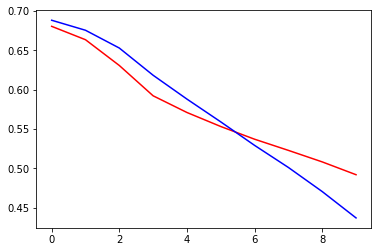

In [19]:
import numpy as np
import matplotlib.pyplot as plt
y_vloss = history.history['val_loss']
y_loss = history.history['loss']

x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, c='red')
plt.plot(x_len, y_loss, c='blue')

### Reviews 데이터 클리닝 작업

In [22]:
import nltk
nltk.download('stopwords')
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
english_stemmer=nltk.stem.SnowballStemmer('english')
from nltk.corpus import stopwords
import re
def review_to_wordlist(review, remove_stopwords = True) :
    
    #review_text 에 알파벳 모두 넣기
    review_text = re.sub('[^a-zA-Z]'," ", review)
    
    # 알파벳 소문자로 바꾸고 분리시켜주기
    words = review_text.lower().split()
    
    if remove_stopwords :
        # english인 불용어 stops 에 넣기
        stops = set(stopwords.words('english'))
        # stops 에 있는 애들만 빼고 words에 넣어준다.
        words = [w for w in words if not w in stops]
        
        
    b=[]
    stemmer = english_stemmer
    # 전처리 된 word 중에서 어간만 빼서 b 에 넣기
    for word in words :
        b.append(stemmer.stem(word))
        
    return(b)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\HOME\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [23]:
clean_reviews = []
for review in data['Reviews']:
    clean_reviews.append(" ".join(review_to_wordlist(review)))

In [24]:
print(len(data['Reviews']))
print(len(clean_reviews))

815
815


In [25]:
data['Reviews'][:3]

2    Good phone for the price, a nice screen with a...
3                               excellent goods for me
4    Love it. Definitely worth the great price. I h...
Name: Reviews, dtype: object

In [26]:
clean_reviews[:3]

['good phone price nice screen nice sound fluid interfac',
 'excel good',
 'love definit worth great price owe mine six month love second alcatel phone owe bought new one readi upgrad love phone price wonder']

In [27]:
df = pd.DataFrame(clean_reviews, data['Rating'], columns = ['Reviews'])
df

,Reviews
Rating,
1,good phone price nice screen nice sound fluid ...
1,excel good
1,love definit worth great price owe mine six mo...
1,pleasant surpris qualiti phone
1,great build qualiti almost stock android littl...
...,...
1,one best phone ever own
1,zte zmax saw zmax came day hassl straight talk...
1,excel


In [28]:
df = df.reset_index()

In [29]:
df

,Rating,Reviews
0,1,good phone price nice screen nice sound fluid ...
1,1,excel good
2,1,love definit worth great price owe mine six mo...
3,1,pleasant surpris qualiti phone
4,1,great build qualiti almost stock android littl...
...,...,...
810,1,one best phone ever own
811,1,zte zmax saw zmax came day hassl straight talk...
812,1,excel
813,1,work great plug sim go cut sim mini micro easi...


In [30]:
df['Rating'].astype('int32')

0      1
1      1
2      1
3      1
4      1
      ..
810    1
811    1
812    1
813    1
814    1
Name: Rating, Length: 815, dtype: int32

In [39]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, LSTM, Dropout
from sklearn.model_selection import train_test_split

import keras
import pandas as pd

#토큰화
token = Tokenizer()
token.fit_on_texts(df['Reviews'])

seq = token.texts_to_sequences(df['Reviews'])
# 패딩
Maxlen = max(len(s) for s in seq)

pad = pad_sequences(seq, Maxlen)

x_train, x_test, y_train, y_test = train_test_split(pad, df['Rating'] , test_size = 0.3, random_state = 1)

# 모형 만들기
num_words =  len(token.index_word) + 1

model = Sequential()
model.add(Embedding(input_dim=num_words, output_dim=8, input_length = Maxlen))
model.add(LSTM(6))
model.add(Dropout(0.01))
model.add(Dense(1,activation='sigmoid'))
model.summary()

# 모델 훈련
model.compile(optimizer='adam', loss = 'binary_crossentropy',metrics=['accuracy'])
model.fit(x_train, y_train, epochs = 10)

# 정확도 계산
print("Trst Accuracy : %.4f" % (model.evaluate(x_test, y_test)[1]))


Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 488, 8)            19144     
_________________________________________________________________
lstm_4 (LSTM)                (None, 6)                 360       
_________________________________________________________________
dropout_3 (Dropout)          (None, 6)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 7         
Total params: 19,511
Trainable params: 19,511
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
18/18 [==============================] - 4s 238ms/step - loss: 0.6853 - accuracy: 0.5912
Epoch 2/10
18/18 [==============================] - 4s 244ms/step - loss: 0.6487 - accuracy: 0.6877
Epoch 3/10
18/18 [==============================